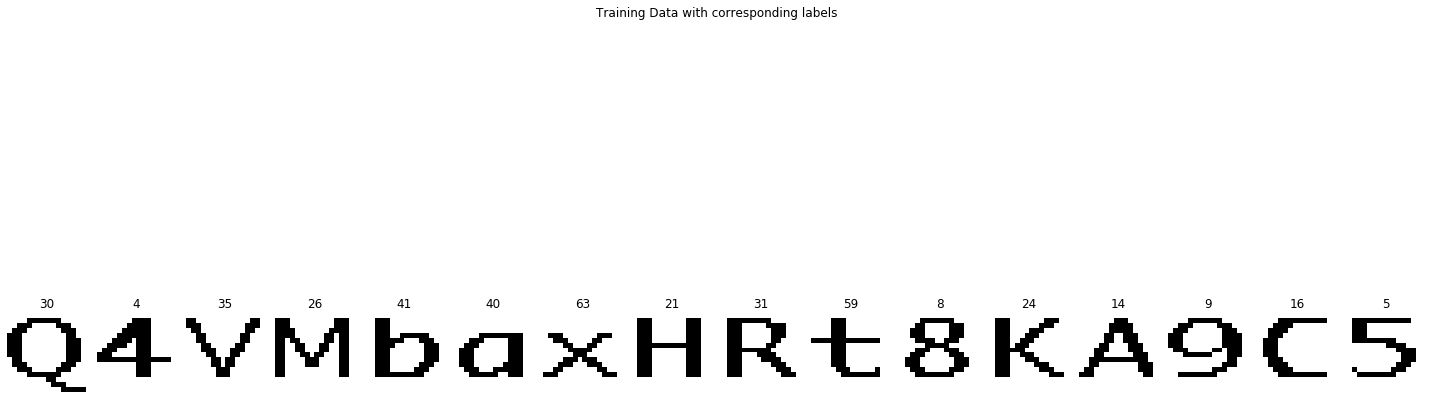

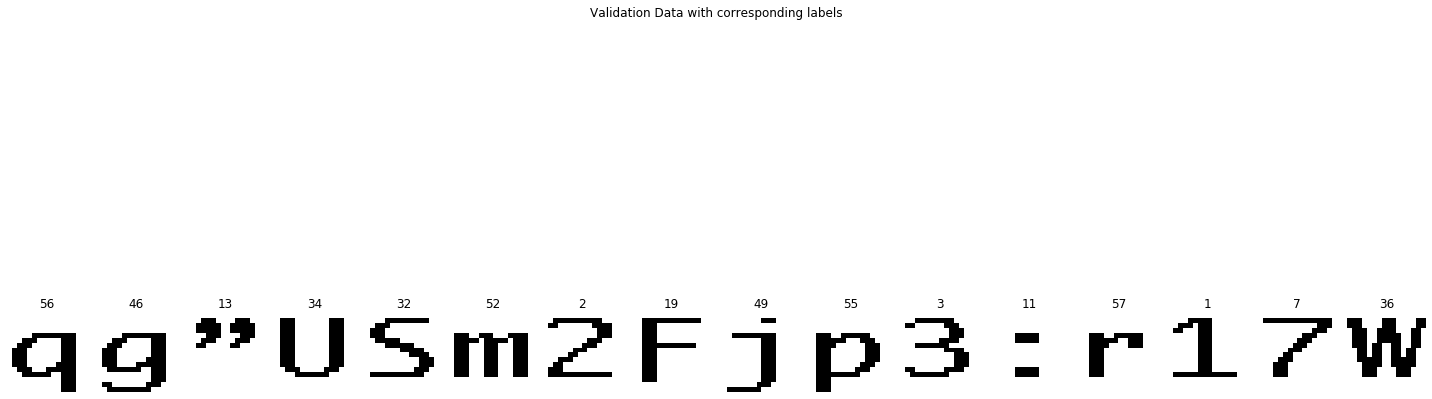

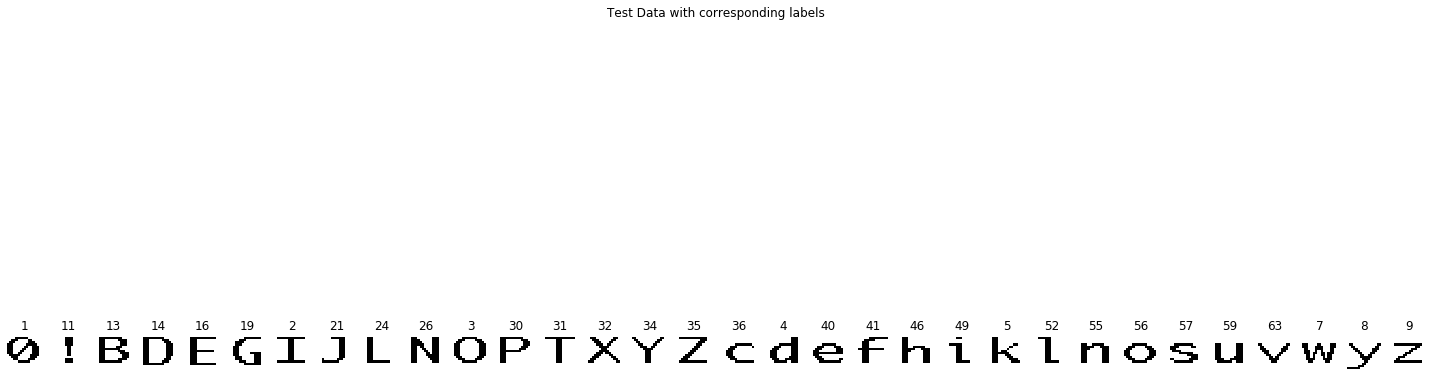

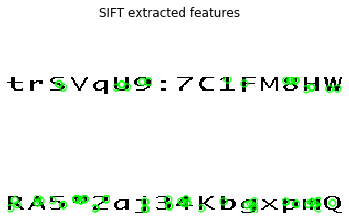

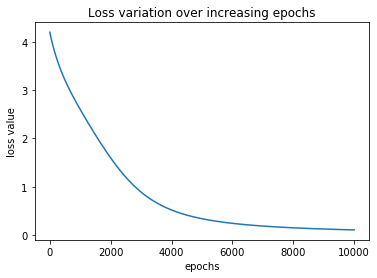

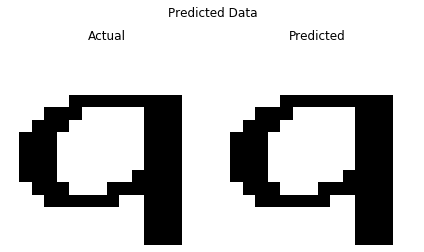

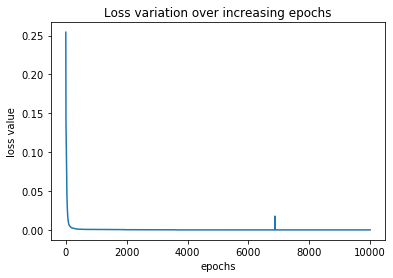

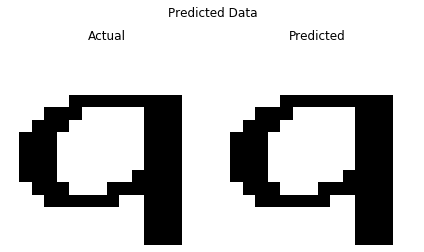

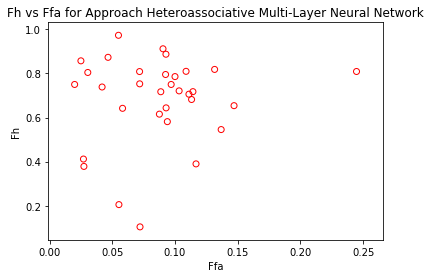

/Library/anaconda3/envs/intel/lib/python3.7/site-packages/ipykernel_launcher.py:373: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/Library/anaconda3/envs/intel/lib/python3.7/site-packages/ipykernel_launcher.py:197: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Library/anaconda3/envs/intel/lib/python3.7/site-packages/ipykernel_launcher.py:198: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a uniq

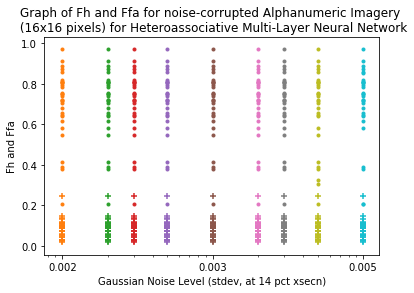

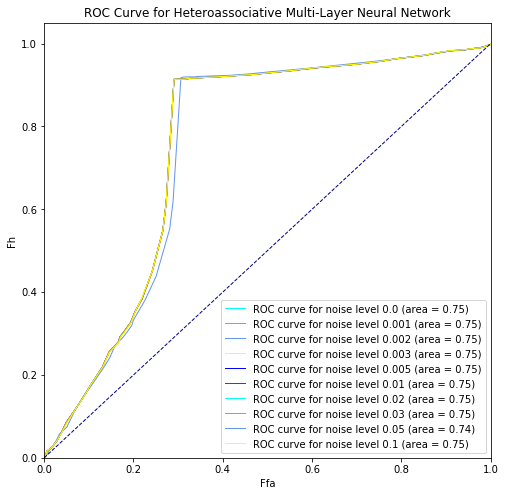

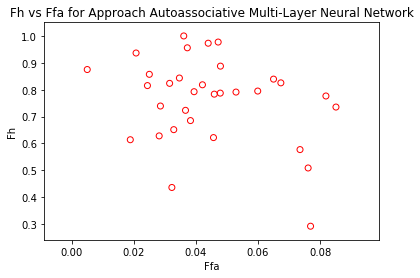

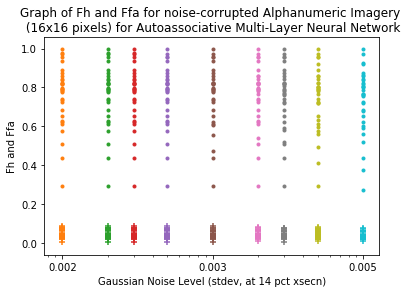

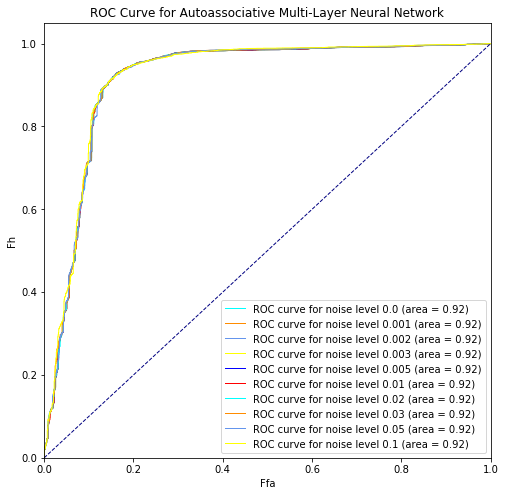

In [8]:
from itertools import cycle
import torch.nn as nn
import torch
import numpy as np
import os
import cv2 as cv
from sklearn import model_selection
from sklearn.metrics import roc_curve, auc
from torch.optim import SGD, Adam
from torchvision import datasets, transforms

import matplotlib.pyplot as plt


""" Multi-Layer Neural Network for MLNN#1

    :arg net_inputs -- number of inputs, flattened out 16x16 image
    :arg num_classes - number of classes, 65 characters from given input

    One hidden layer with 1000 nodes, LogSoftmax activation for final classification

"""


class DClassNet(nn.Module):
    def __init__(self, net_inputs, num_classes):
        super(DClassNet, self).__init__()
        self.mlnn = nn.Sequential(
            nn.Linear(net_inputs, 1000),
            nn.ReLU(),
            nn.Linear(1000, num_classes),
            nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.mlnn(x)
        return x


""" Multi-Layer Neural Network for MLNN#2

    :arg net_inputs -- number of inputs, flattened out 16x16 image

    One hidden layer with 1000 nodes, Sigmoid activation

"""


class DNet(nn.Module):
    def __init__(self, net_inputs):
        super(DNet, self).__init__()
        self.mlnn = nn.Sequential(
            nn.Linear(net_inputs, 1000),
            nn.ReLU(),
            nn.Linear(1000, net_inputs),
            nn.Sigmoid())

    def forward(self, x):
        x = self.mlnn(x)
        return x

# Noise is Gaussian with 10 percent cross-section
class GaussianNoiseTransform(object):
    def __init__(self, mean=0., std=1., k=25):
        self.std = std
        self.mean = mean
        self.k = k

    def __call__(self, tensor):
        # reshape and flatten
        x_transf = torch.flatten(tensor[0, :], start_dim=0)

        n = x_transf.size(0)
        perm = torch.randperm(n)
        idx = perm[:(n - self.k)]

        noise = torch.randn(x_transf.size())
        # only 10% is noise
        noise[idx] = 0.

        corrupted_image = x_transf + noise * self.std + self.mean
        # renormalize
        corrupted_image -= corrupted_image.min(0, keepdim=True)[0]
        corrupted_image /= corrupted_image.max(0, keepdim=True)[0]

        tensor[0, :] = corrupted_image.reshape(16, 16)

        return tensor

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class Plotter:
    @staticmethod
    def plot_data(image_datasets, x_train, y_train, title, kind='train'):
        # plot train data with labels
        R, C = 1, x_train.size(0)
        fig, ax = plt.subplots(R, C, figsize=(20, 10))
        fig.suptitle(title)
        for i, plot_cell in enumerate(ax):
            plot_cell.grid(False)
            plot_cell.axis('off')
            plot_cell.set_title(image_datasets[kind].classes[y_train[i].item()])
            plot_cell.imshow(x_train[i][0], cmap='gray')
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_losses(loss_history):
        plt.plot(loss_history)
        plt.title('Loss variation over increasing epochs')
        plt.xlabel('epochs')
        plt.ylabel('loss value')
        plt.show()

    @staticmethod
    def plot_stats(fh, ffa, approach):
        network = "Heteroassociative Multi-Layer Neural Network" if approach == 1 else "Autoassociative Multi-Layer Neural Network"
        plt.scatter(ffa, fh, facecolors='none', edgecolors='r')
        plt.title(f'Fh vs Ffa for Approach {network}')
        plt.xlabel('Ffa')
        plt.ylabel('Fh')
        plt.show()

    @staticmethod
    def plot_sample(x, y):
        # # plot predicted data with
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Predicted Data')
        ax1.grid(False)
        ax1.axis('off')
        ax1.set_title('Actual')
        ax1.imshow(x, cmap='gray')

        ax2.grid(False)
        ax2.axis('off')
        ax2.set_title('Predicted')
        ax2.imshow(y.detach().numpy(), cmap='gray')

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_class_roc(actuals, class_probabilities):
        fpr, tpr, _ = roc_curve(actuals, class_probabilities)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

    @staticmethod
    def plot_noise_roc(probs, approach):
        network = "Heteroassociative Multi-Layer Neural Network" if approach == 1 else "Autoassociative Multi-Layer Neural Network"
        plt.figure(figsize=(8, 8))
        lw = 1

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'yellow', 'blue', 'red'])
        for (noise, (actuals, class_probabilities)), color in zip(probs.items(), colors):
            fpr, tpr, _ = roc_curve(actuals, class_probabilities)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, color=color,
                     lw=lw, label='ROC curve for noise level {0} (area = {1:0.2f})'.format(noise, roc_auc))

        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Ffa')
        plt.ylabel('Fh')
        plt.title(f'ROC Curve for {network}')
        plt.legend(loc="lower right")
        plt.show()

    @staticmethod
    def plot_noise_stats(stats, approach):
        network = "Heteroassociative Multi-Layer Neural Network" if approach == 1 else "Autoassociative Multi-Layer Neural Network"

        x, y, z = [], [], []
        for sdev, (Fh, Ffa) in stats.items():
            x.append(sdev)
            y.append(Fh)
            z.append(Ffa)

        for xe, ye in zip(x, y):
            plt.scatter([xe] * len(ye), ye, marker='.')
        for xe, ze in zip(x, z):
            plt.scatter([xe] * len(ze), ze, marker='+')

        plt.xticks(x)
        plt.axes().set_xscale('log')
        plt.axes().set_xticklabels(x)
        # plt.legend(labels=x)
        plt.title(
            f'Graph of Fh and Ffa for noise-corrupted Alphanumeric Imagery \n (16x16 pixels) for {network}')
        plt.xlabel('Gaussian Noise Level (stdev, at 14 pct xsecn)')
        plt.ylabel('Fh and Ffa')
        plt.show()

class FeaturesController:

    def extract_sift_features(self, image, vector_size=16 * 16):
        alg = cv.SIFT_create()
        # image keypoints
        kps = alg.detect(image)

        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value(bigger is better)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])

        return dsc

    def extract_features(self, images, vector_size=16 * 16):
        features = self.extract_sift_features(images[0], vector_size)
        for i in range(1, images.shape[0]):
            features = np.vstack((features, self.extract_sift_features(images[i], vector_size)))

        return features

    def plot_sift_descriptors(self, path, vec_size=16 * 16):
        fig, (axes1, axes2) = plt.subplots(2, 16)
        fig.suptitle('SIFT extracted features')

        for i, f in enumerate(os.listdir(path)):
            axes = axes1 if i < 16 else axes2
            idx = i if i < 16 else 16-i
            img_name = os.listdir(f'{path}/{f}')
            img = cv.imread(f'{path}/{f}/{img_name[0]}')
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

            alg = cv.SIFT_create()
            kp = alg.detect(img)

            kp = sorted(kp, key=lambda x: -x.response)[:vec_size]
            # computing descriptors vector
            kp, dsc = alg.compute(img, kp)

            img2 = cv.drawKeypoints(img, kp, None, color=(0, 255, 0), flags=0)
            axes[idx].grid(False)
            axes[idx].axis('off')
            axes[idx].imshow(img2)

        plt.show()

class TrainingPipeline:
    def __init__(self):
        self.models = [DClassNet(16 * 16, 65), DNet(16 * 16)]
        self.loss = [nn.NLLLoss(),  # negative log-likelihood loss, needed for classification of 65 objects
                     nn.MSELoss()]
        self.optimizer = self.init_optimizer(1)
        self.features_controller = FeaturesController()

    def init_optimizer(self, approach):
        self.optimizer = [SGD(self.models[approach - 1].parameters(), lr=0.001),
                          Adam(self.models[approach - 1].parameters(), lr=0.001)]

        return self.optimizer

    def plot_features(self, x):
        self.features_controller.plot_sift_descriptors(x)

    # Will try 2 approaches as listed in Step 02
    def get_model(self, approach):
        model = self.models[approach - 1]
        loss_fn = self.loss[approach - 1]
        optimizer = self.optimizer[approach - 1]
        return model, loss_fn, optimizer

    """ Negative log-likelihood loss and LogSoftmax together are the cross-entropy loss"""

    def train(self, x, y, model, optimizer, loss_fn, num_epochs=10000):

        loss_history = []
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            pred = model(x)
            loss_value = loss_fn(pred, y)
            loss_value.backward()
            optimizer.step()
            loss_history.append(loss_value)

        return loss_history

    @torch.no_grad()
    def val_loss(self, x, y, model, loss_fn):
        prediction = model(x)
        val_loss = loss_fn(prediction, y)
        return val_loss.item()

    # Create training and validation datasets and initialize data loaders
    def initialize_data(self, data_dir, sdev=0.):
        data_transforms = {
            'train': transforms.Compose([
                transforms.ToTensor()
            ]),
            'test': transforms.Compose([
                transforms.ToTensor()
            ]),
            'raw': transforms.Compose([
                transforms.ToTensor()
            ])
        } if sdev == 0. else {
            'train': transforms.Compose([
                transforms.ToTensor()
            ]),
            'test': transforms.Compose([
                transforms.ToTensor(),
                GaussianNoiseTransform(std=sdev, k=25)
            ]),
            'raw': transforms.Compose([
                transforms.ToTensor(),
                GaussianNoiseTransform(std=sdev, k=25)
            ]),
        }

        # Create training and validation datasets
        image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in
                          ['train', 'test', 'raw']}
        # Create training and validation dataloaders
        image_dataloaders = {
            x: torch.utils.data.DataLoader(image_datasets[x], batch_size=image_datasets[x].__len__(),
                                           shuffle=True if x == 'train' else False)
            for x
            in
            ['train', 'test', 'raw']}

        return image_datasets, image_dataloaders

    def load_all_data(self, image_dataloaders, kind='train'):
        # load
        X_train, Y_train = next(iter(image_dataloaders[kind]))
        # reshape and flatten
        X_train_f = torch.flatten(X_train[:, 0], start_dim=1)

        return X_train, Y_train, X_train_f

    @torch.no_grad()
    def predict(self, approach_number, model, x, x_test):
        if approach_number == 1:
            img = x.view(1, 16 * 16)
            y_pred = model(img)
            # Predictions are log-probabilities, do exponentials for real probabilities
            probs = list(torch.exp(y_pred).numpy()[0])
            # The index of the output pattern is found by locating the maximum value of y,
            # then finding the indx j of that value
            y = probs.index(max(probs))
            return x_test[y - 1]

        elif approach_number == 2:
            y_pred = model(x)
            return y_pred

    @torch.no_grad()
    def get_class_probabilities(self, classifier, x, x_test):
        classifier.eval()
        output = classifier(x)
        prediction = output.argmax(dim=1, keepdim=True)
        pred_images = x_test[prediction - 1]
        actuals = torch.round(x.view_as(pred_images))
        sm = torch.nn.Softmax()
        probabilities = sm(pred_images)

        return [p.item() for i in actuals for j in i for p in j], [p.item() for i in probabilities for j in i for p in
                                                                   j]

    @torch.no_grad()
    def get_image_probabilities(self, classifier, x, x_raw_f):
        classifier.eval()
        output = classifier(x)
        sm = torch.nn.Softmax()
        probabilities = sm(output)
        actuals = torch.round(x.view_as(x))

        return [j.item() for i in actuals for j in i], [j.item() for i in probabilities for j in i]

    def run_approach(self, approach_number, x_train_f, x_train, x_test, y_train, image_datasets):
        self.init_optimizer(approach_number)
        # setup labeling indexed list
        labels = [torch.LongTensor([float(image_datasets['train'].classes[lookup]) for lookup in y_train]),
                  x_train_f
                  ]
        model, loss_func, opt = self.get_model(approach_number)

        loss_history = self.train(x_train_f, labels[approach_number - 1],
                                  model, opt, loss_func)
        Plotter.plot_losses(loss_history)

        y_test_pred = self.predict(approach_number, model, x_train_f[0], x_test)
        y_pred = y_test_pred.reshape(16, 16)
        Plotter.plot_sample(x_train[0][0], y_pred)

        return model

    def load_pretrained(self, path):
        _models = []
        for approach_num in range(1, 3):
            model, _, _ = self.get_model(approach_num)
            model.load_state_dict(torch.load(f'{path}/model{approach_num}.pth'))
            model.eval()
            _models.append(model)

        return _models

    def render_test_data(self, m, x, x_raw):
        for i, model in enumerate(m):
            for x_test in x:
                # apply the model
                y_pred = self.predict(i + 1, model, x_test, x_raw)
                if i == 1:
                    Plotter.plot_sample(x_test.reshape(16, 16), y_pred.reshape(16, 16))

    @torch.no_grad()
    def get_fraction_statistics(self, x_test, y_pred):
        a = torch.round(x_test)
        b = torch.round(y_pred)
        diff = abs(a - b)

        blacks = a == 0
        whites = a == 1

        z = torch.logical_and(diff == 0, blacks).sum()
        fh = z.item() / blacks.sum().item()

        z = torch.logical_and(diff == 1, whites).sum()
        ffa = z.item() / whites.sum().item()

        return fh, ffa

    def compute_statistics(self, model, x, x_raw_f,  approach=1):
        Fh = []
        Ffa = []
        for x_test in x:
            # apply the model
            y_pred = self.predict(approach, model, x_test, x_raw_f)

            fh, ffa = self.get_fraction_statistics(x_test, y_pred)

            Fh.append(fh)
            Ffa.append(ffa)

        return Fh, Ffa

    def get_noise_stats(self, data_dir, model, sdevs, approach, x_raw_f, render=False):
        stats = {}
        img_probs = {}
        for sd in sdevs:
            image_datasets, loaders = self.initialize_data(data_dir, sdev=sd)
            X_test, Y_test, X_test_f = self.load_all_data(loaders, kind='test')

            # plot train data with labels
            if render:
                Plotter.plot_data(image_datasets, X_test, Y_test, kind='test')

            # calculate statistics
            stats[sd] = self.compute_statistics(model, X_test_f, x_raw_f, approach)
            img_probs[sd] = self.get_image_probabilities(model,
                                                         X_test_f,
                                                         x_raw_f) if approach == 2 else self.get_class_probabilities(
                model, X_test_f, x_raw_f)

        return stats, img_probs

    def save_models(self, path, models):
        for approach_num, model in enumerate(models):
            torch.save(model.state_dict(), f'{path}/model{approach_num + 1}.pth')

data_dir = "data"

pipeline = TrainingPipeline()
image_datasets, loaders = pipeline.initialize_data(data_dir)
X_train, Y_train, X_train_f = pipeline.load_all_data(loaders)
X_raw, Y_raw, X_raw_f = pipeline.load_all_data(loaders, kind='raw')
X_test, Y_test, X_test_f = pipeline.load_all_data(loaders, kind='test')

X_t, X_validate, y_t, y_validate = model_selection.train_test_split(X_train, Y_train, train_size=0.5)

# plot train data with labels
Plotter.plot_data(image_datasets, X_t, y_t, "Training Data with corresponding labels")
# plot validate data with labels
Plotter.plot_data(image_datasets, X_validate, y_validate, "Validation Data with corresponding labels")
# plot test data with labels
Plotter.plot_data(image_datasets, X_test, Y_test, "Test Data with corresponding labels")

# Plot features extracted by SIFT
pipeline.plot_features('data/train')

# train model for Approach1
model1 = pipeline.run_approach(1, X_train_f, X_train, X_raw_f, Y_train, image_datasets)
# #get info for ROC
# actuals, class_probabilities = pipeline.get_class_probabilities(model1, X_test_f, X_raw_f)
# Plotter.plot_class_roc(actuals, class_probabilities)

# # train model for Approach2
model2 = pipeline.run_approach(2, X_train_f, X_train, X_test_f, Y_train, image_datasets)
# # get info for ROC
# actuals, class_probabilities = pipeline.get_image_probabilities(model2, X_test_f)
# Plotter.plot_class_roc(actuals, class_probabilities)

#models = pipeline.load_pretrained(".")
# decide which model is better
models = [model1, model2]
# pipeline.save_models(".", models)
#pipeline.render_test_data(models, X_test_f, X_raw_f)

# corrupt all images with Gaussian noise
sdevs = [0., 0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
# calculate statistics
for idx, model in enumerate(models):
    Fh, Ffa = pipeline.compute_statistics(model, X_test_f,  X_raw_f, idx+1)
    Plotter.plot_stats(Fh, Ffa, idx+1)

    stats, probs = pipeline.get_noise_stats(data_dir, model, sdevs, idx+1, X_raw_f)
    #pd.DataFrame.from_dict(data=stats).to_csv(f'data-model{idx+1}.csv', header=False)

    Plotter.plot_noise_stats(stats, idx+1)
    Plotter.plot_noise_roc(probs, idx+1)